# Problem 1

# 1a.

The value function is

$$V(k, A) = \max_{0\leq k' \leq k}\left[\log\left(Ak^\alpha + (1 - \beta)k - k'\right) + \beta\int V(k', A')P(A, dA')\right]$$

The FOC is

$$-\left(AK^\alpha + (1 - \beta)k - k'\right)^{-1} + \beta\int \frac{\partial}{\partial k'} V(k', A')P(A, dA')$$

# 1b.

In [1]:
%matplotlib notebook
import numpy as np
import scipy.io as spio
import matplotlib
import matplotlib.pyplot as plt
import sys

mat = spio.loadmat('rwout.mat', squeeze_me=True)

In [6]:
beta = 0.96
rho = 0.9
sigma = 0.02
alpha = 0.3
delta = 0.08
epsilon = 10**(-5)

N_A = 100
N_k = 100
logA = mat['Lambda'].reshape(N_A, 1) # Column Vector
A = np.exp(logA)
A_t = A.reshape(N_A)
P = np.asarray(mat['P'])
k_ss = (alpha*A[-1]/(1/beta - (1 - delta)))**(1/(1-alpha))
k = np.linspace(0.1*k_ss, k_ss, N_k) # Row Vector

# The coordinates of inst_payoff refer to (j', i, j), respectively.
inst_payoff = np.log(A*(k**alpha) + (1 - delta)*k - k.reshape(N_k,1,1))
# Negative consumption is automatically maked out by the log function.

def update_V(V):
    return np.nanmax(inst_payoff + beta*P.dot(V).transpose().reshape(N_k, N_A, 1), 0)

def get_value_function():
    V_last = V = np.ones([N_A, N_k])
    V = update_V(V)
    while(np.nanmax(abs(V - V_last)) > epsilon):
        V_last = V
        V = update_V(V)
    return V

def get_policy_function_indices(V):
    return np.nanargmax(inst_payoff + beta*P.dot(V).transpose().reshape(N_k, N_A, 1), 0)

def get_policy_function(V):
    policy_fn_ind = get_policy_function_indices(V)
    policy_fn = [[k[ind] for ind in row] for row in policy_fn_ind]
    return np.asarray(policy_fn)

def get_k_A_path_indices(policy_fnc_ind, k_index = 50, A_index = 50, T = 1000):
    A_path = np.empty(1000)
    k_path = np.empty(1000)
    for n in range(T):
        k_next = policy_fnc_ind[A_index][k_index]
        A_next = np.random.choice(range(len(A)), p = P[A_index])
        A_path[n] = A_index = A_next
        k_path[n] = k_index = k_next
    return np.asarray(k_path, dtype=int), np.asarray(A_path, dtype=int)


def get_k_A_path(policy_fnc_ind, k_index = 50, A_index = 50, T = 1000):
    k_path, A_path = get_k_A_path_indices(policy_fnc_ind, k_index, A_index, T)
    return np.asarray([k[int(ind)] for ind in k_path]), np.asarray([A[int(ind)][0] for ind in A_path])
    
def plot_simulation_paths(k_index = 50, A_index = 50, T = 1000):
    fig, (axA, axk, axc, axi) = plt.subplots(nrows = 4)
    policy_fnc_ind = get_policy_function_indices(get_value_function())
    k_path, A_path = get_k_A_path(policy_fnc_ind, k_index, A_index, T)
    c_path = A_path*(k_path**alpha) + (1 - delta)*k_path - np.roll(k_path, -1)
    c_path[-1] = np.nan
    i_path = np.roll(k_path, -1) - (1 - delta)*k_path
    i_path[-1] = np.nan
    axA.plot(A_path)
    axA.set_title('Simulated Path')
    axA.set_ylabel('TFP')
    axk.plot(k_path)
    axk.set_ylabel('Capital Stock')
    axc.plot(c_path)
    axc.set_ylabel('Consumption')
    axi.plot(i_path)
    axi.set_ylabel('Investment')
    axi.set_xlabel('t')

    plt.show()

def plot_value_functions(As = [60,40,20]):
    V = get_value_function()
    fig, axes = plt.subplots()
    for A_plot in As:
        axes.plot(k, V[A_plot], label = "A = {0}".format(A[A_plot][0]))
    axes.set_title('Value Function')
    axes.set_xlabel('k')
    axes.set_ylabel('V(k)')
    plt.legend(loc=4)
    plt.show()
    
def plot_policy_functions(As = [60,40,20]):
    V = get_value_function()
    pol_fn = get_policy_function(V)
    fig, axes = plt.subplots()
    for A_plot in As:
        g = pol_fn[A_plot]
        axes.plot(k, g, label = "A = {0}".format(A[A_plot][0]))
    axes.set_title('Policy Function')
    axes.set_xlabel('k')
    axes.set_ylabel('g(k)')
    plt.legend(loc=4)
    plt.show()

def get_k_dist(ts = [5,20,100,200,500], T = 1000, N = 1000):
    policy_fnc_ind = get_policy_function_indices(get_value_function())
    values_at_t = np.empty([len(ts), N])
    for n in range(N):
        k_path, A_path = get_k_A_path(policy_fnc_ind, T = T)
        for t_ind in range(len(ts)):
            values_at_t[t_ind][n] = k_path[ts[t_ind]]
        sys.stdout.write("\rn = {0}".format(n + 1))
        sys.stdout.flush()
    sys.stdout.write("\r")
    sys.stdout.flush()
    return values_at_t

def plot_k_dist(ts = [5,20,100,200,500], T = 1000, N = 1000):
    values_at_t = get_k_dist(ts, T, N)
    fig, axes = plt.subplots()
    for t_ind in range(len(ts)):
        t_cdf = [(len([0 for k_j in values_at_t[t_ind] if (k_j <= k_i)])/T) for k_i in k]
        axes.plot(k, t_cdf, label = "t = {0}".format(ts[t_ind]))
    axes.set_title('CDF of k at time t')
    axes.set_xlabel('k')
    axes.set_ylabel('CDF')
    plt.legend(loc=4)
    plt.show()

/home/jeffrey/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log


# 1c.

<IPython.core.display.Javascript object>


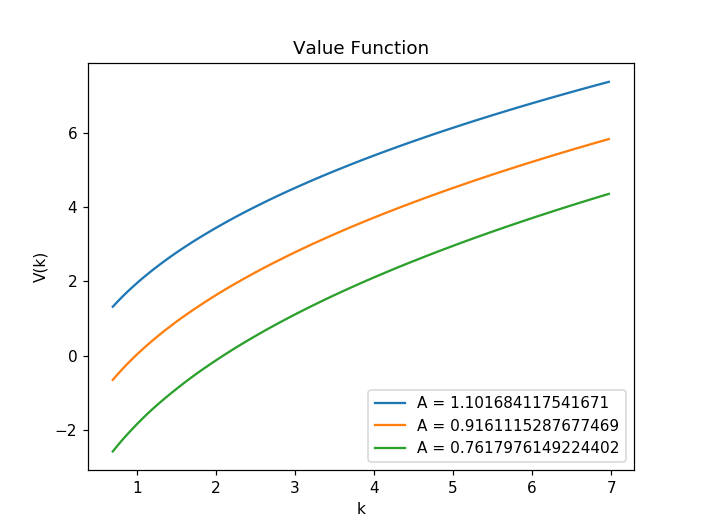

In [3]:
plot_value_functions()

# The value functions appear to be strictly increasing, strictly concave, and satisfying the first Inada condition.

# The value function shifts up with increases in A. The value functions for different levels of A look
# approximately like multiples of each other.

<IPython.core.display.Javascript object>


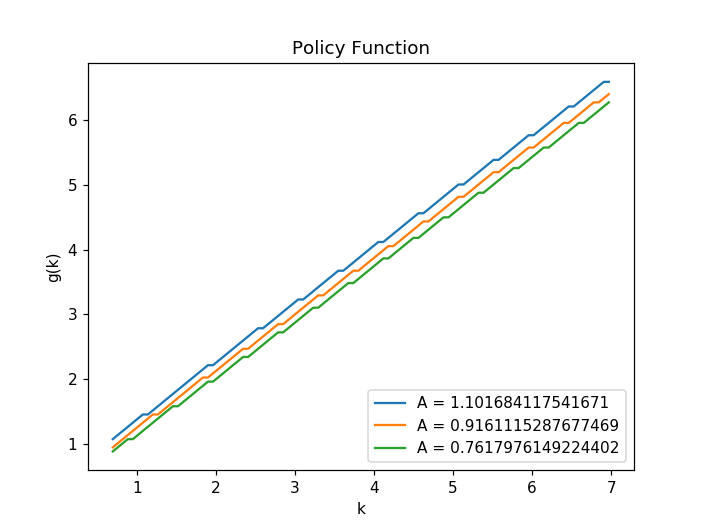

In [4]:
plot_policy_functions()

# The policy functions are very close to linear, and very close to the identity. This indicates gradual optimal
# changes in consumption.
# The policy function shifts up with increases in A, and the difference grows with higher k. That is, the slope
# of the policy function increases with A.

# 1d.

<IPython.core.display.Javascript object>


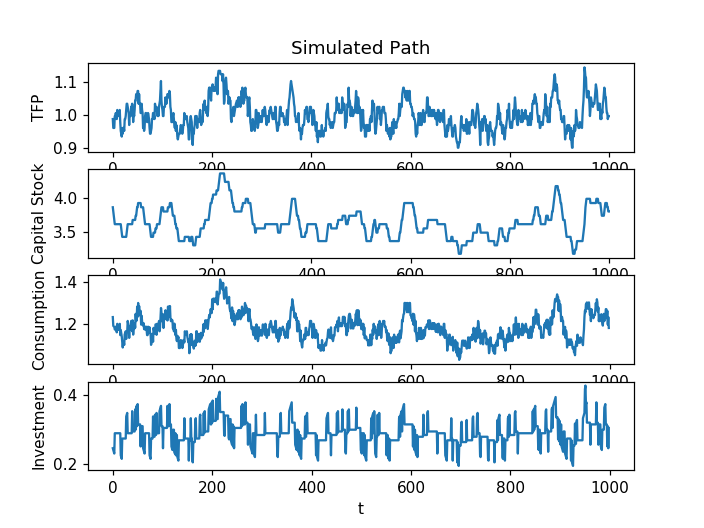

In [7]:
plot_simulation_paths()

# Consumption is the most volatile, and investment is the least. This is because the consumer is reacting to TFP
# shocks by adjusting consumption in the current state, in order to reach nearby optimal values of capital. This
# is done with short-lived, dramatic adjustments, "pulses", to investment, which we see in the investment path.

# 1e.

<IPython.core.display.Javascript object>


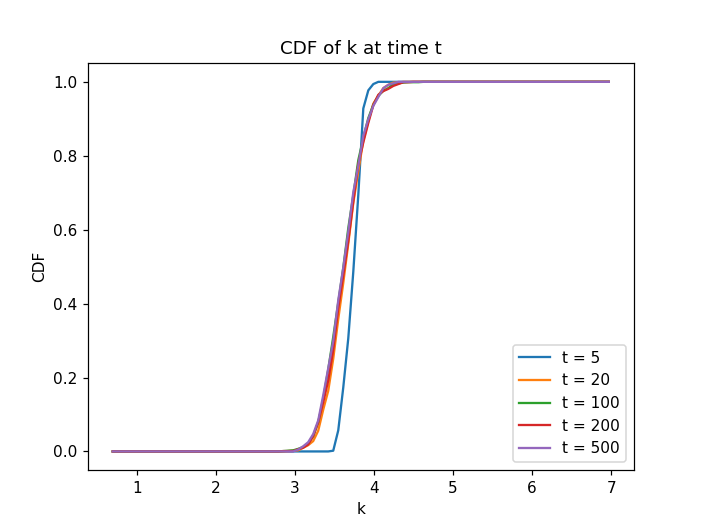

In [8]:
plot_k_dist()

# The capital stock converges to a steady state in that, as t gets large, capital at t is distributed close
# to a fixed distribution that looks approximately normal. That is, capital at t converges in distribution
# as t gets large.